In [11]:
import torch
import numpy as np
import onnx
import onnxruntime
import os
import WDNet
import matplotlib.pyplot as plt
import torchvision

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
model_path = '../../YandexDisk\ML_models\model_WDNet' # local drive
device = 'cpu'

In [3]:
#load torch model
torch_model = WDNet.generator(3,3)
torch_model.load_state_dict(torch.load(os.path.join(model_path,'WDNet_G.pkl')))
torch_model.eval()
torch_model.to(device)
print('torch model loaded')

torch model loaded


In [83]:
#export onnx model
rnd_inp = torch.randn(1, 3, 16, 16, requires_grad=True)
onnx_path = os.path.join(model_path,'WDnet_G.onnx')

#dynamic axes in order to make model compatitable with different image sizes
dynamic_axes = {
    'input':  {2:"img_w",3:"img_h"},
    'output': {2:"img_w",3:"img_h"}
}

dynamic_axes = {
    'input':  [2,3],
    'output': [2,3]
}

torch.onnx.export(torch_model,rnd_inp,onnx_path,
                  input_names=['input'],
                  output_names=['output'],
                  dynamic_axes=dynamic_axes)

#load onnx model
onnx_model = onnx.load(onnx_path)
onnx.checker.check_model(onnx_model)
print('\nonnx model checekd')


onnx model checekd


In [84]:
#pick-up test image
test_img_path = os.path.join('test_img','wm2_16.jpg')
test_img = torchvision.io.read_image(test_img_path)
test_img = test_img.float() / 255
test_img = test_img.unsqueeze(0)
test_img = test_img.to(device)
test_img_numpy = to_numpy(test_img)
print(f'torch shape: {test_img.shape}')
print(f'numpy shape: {test_img_numpy.shape}')
print(f'device: {device}')

torch shape: torch.Size([1, 3, 336, 512])
numpy shape: (1, 3, 336, 512)
device: cpu


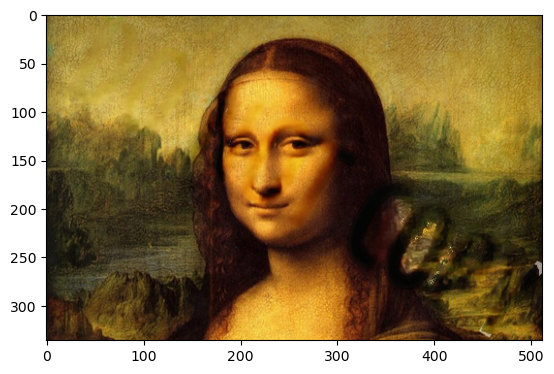

In [85]:
# torch
with torch.no_grad():
    torch_out = torch_model(test_img)
pil_image = torchvision.transforms.functional.to_pil_image(torch_out[0].squeeze(0))
plt.imshow(pil_image)

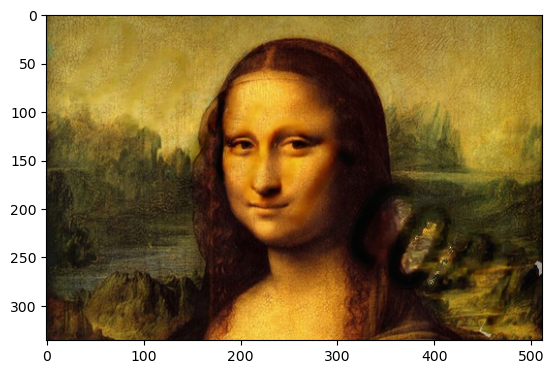

In [86]:
ort_session = onnxruntime.InferenceSession(onnx_path, providers=["CPUExecutionProvider"])
ort_inputs = {ort_session.get_inputs()[0].name: test_img_numpy}
onnx_out = ort_session.run(None, ort_inputs)

# bad way to show image 
onnx_torch = torch.from_numpy(onnx_out[0]).squeeze(0)
pil_image = torchvision.transforms.functional.to_pil_image(onnx_torch)
plt.imshow(pil_image)

In [87]:
with torch.no_grad():
    for i in range(10):
        torch_out = torch_model(test_img)

In [88]:
for i in range(10):
    onnx_out = ort_session.run(None, ort_inputs)

In [66]:
#something rong with numpy-image conversion
from PIL import Image

np_img = np.rint(onnx_out[0]*255).squeeze() #CHW
np_img = np.transpose(np_img, axes=[1,2,0]) #HWC
np_img.shape

onnx_image = Image.fromarray(np_img,mode='RGB')
plt.imshow(onnx_image)

TypeError: Cannot handle this data type: (1, 1, 3), <f4